In [16]:
import torch
import torch.autograd as autograd
import numpy as np
import torch.optim as optim

# This method creates a pytorch model
def create_model(idim, odim, hdim1, hdim2):
    model = torch.nn.Sequential(
            torch.nn.Linear(idim, hdim1),
            torch.nn.BatchNorm1d(hdim1),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(hdim1, hdim2),
            torch.nn.BatchNorm1d(hdim1),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(hdim2, odim),
            torch.nn.LogSoftmax()
            )
    return model

In [79]:
# This method trains a model with the given data
# Epoch is the number of training iterations
# lrate is the learning rate
def nn_train(train_x, train_y, model, epoch, lrate, batch_size):
    inputs = []


    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

    for itr in range(epoch):
        ## MINI-BATCH: Shuffles the training data to sample without replacement
        indices = list(range(0, train_x.shape[0]))
        np.random.shuffle(indices)
        train_x = train_x[indices,:]
        train_y = train_y[indices]
        for i in range(0, train_x.shape[0], batch_size):
            # Get pair of (X, y) of the current mini-batch
            x_batch = train_x[i:i+batch_size]
            y_batch = train_y[i:i+batch_size]
            
            X = autograd.Variable(torch.from_numpy(x_batch), requires_grad=True).float()
            Y = autograd.Variable(torch.from_numpy(y_batch), requires_grad=False).long()  
            
            y_pred = model(X)

            loss = loss_fn(y_pred, Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
#        print("Epoch: {}  Acc: {}".format(itr,nn_test(test_x,test_y,model)))

    return model

In [18]:
# Pass the trained model along with test data to this method to get accuracy
# The method return accuracy value
def nn_test(test_x, test_y, model):

    X = autograd.Variable(torch.from_numpy(test_x), requires_grad=False).float()
    y_pred = model(X)
    _ , idx = torch.max(y_pred, 1)

#    test_y = test_y.values[:,0]
    return (1.*np.count_nonzero((idx.data.numpy() == test_y).astype('uint8')))/len(test_y)

In [19]:
def normalize(data_list):
    # compute normalization parameter
    utter = np.concatenate(data_list, axis=0)
    mean  = np.mean(utter)
    utter -= mean
    std   = np.std(utter)
    utter /= std

    # normalize data
    for data in data_list:
        data -= mean
        data /= std

    return data_list

In [20]:
# Method reads training data and drops loan id field
def read_train_data(filename):
    f = open(filename, "r")
    x = []
    y = []
    content = f.readlines() 

    for i in range(1, len(content)):
        line = content[i]
        line.strip()
        line = line.split(",")
        y.append(line[len(line)-1])
        line = line[1:len(line)-1]
        x.append(line)


    x = np.array(x)
    x = x.astype(np.float)

    y = np.array(y)
    y = y.astype(np.int)
    return (x,y)

In [21]:
# Method reads features of test data
def read_test_data_x(filename):
    f = open(filename, "r")
    x = []
    content = f.readlines() 

    for i in range(1, len(content)):
        line = content[i]
        line.strip()
        line = line.split(",")
        line = line[1:len(line)-1]
        x.append(line)


    x = np.array(x)
    x = x.astype(np.float)

    return x


In [22]:
# Method reads labels of test data
def read_test_data_y(filename):
    f = open(filename, "r")
    y = []
    content = f.readlines() 

    for i in range(1, len(content)):
        line = content[i]
        line.strip()
        line = line.split(",")
        y.append(line[len(line)-1])



    y = np.array(y)
    y = y.astype(np.int)
    return y

In [80]:
# find the best gradient descent step length and the best batch size of NN
def main():

    # pytorch nn code
    # Use this main code to understand how the methods are used
    # There are two methods nn_train, which is used to train a model (created using create_model method)
    # Other than data nn train takes learning rate and number of iterations as parameters. 
    # Please change the given values for your experiments.
    # nn_train returns a trained model
    # pass this model to nn_test to get accuracy
    # nn_test return 0/1 accuracy 
    # Please read pytorch documentation if you need more details on implementing nn using pytorch
    # training and test data is read as numpy arrays
    train_x, train_y = read_train_data("train.csv")
    test_x = read_test_data_x("test.csv")
    test_y = read_test_data_y("pred.csv")


  # You can use python pandas if you want to fasten reading file , the code is commented
  #  df = pd.read_csv("train.csv")
  #  train_x = df.drop(columns = ['Loan ID','Status (Fully Paid=1, Not Paid=0)'], axis = 1)
  #  train_y = df['Status (Fully Paid=1, Not Paid=0)']
  #  train_x = train_x.values
  #  train_y = train_y.values

  #  df = pd.read_csv("test.csv")
  #  test_x = df.drop(columns = ['Loan ID','Status (Fully Paid=1, Not Paid=0)'], axis = 1)
  #  test_x = test_x.values
  #  df = pd.read_csv("pred.csv")
  #  test_y = df.drop(columns = ['Loan ID'], axis = 1)

    train_x[np.isnan(train_x)] = 0
    test_x[np.isnan(test_x)] = 0
    #print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
    
    train_x = normalize(train_x)
    idim = 25  # input dimension
    hdim1 = 64 # hidden layer one dimension
    hdim2 = 64 # hidden layer two dimension
    odim = 2   # output dimension
    best_model = None
    best_acc_nn = 0
    best_learning_rate = 0 
    best_batch_size = 0
    
    for learning_rate in [1, 1e-1, 1e-2]:
        for batch_size in [300, 500, 800]:
            model = create_model(idim, odim, hdim1, hdim2) # creating model structure
            trained_model = nn_train(train_x, train_y, model, 300, learning_rate, batch_size) # training model
            acc_nn = nn_test(test_x, test_y, trained_model) # testing model
            if acc_nn > best_acc_nn:
                best_acc_nn = acc_nn
                best_model = model
                best_learning_rate = learning_rate
                best_batch_size = batch_size
    
    print("accuracy is {}, learning rate is {}, batch size is {}" .format(best_acc_nn, best_learning_rate, best_batch_size))

main()

C:\Users\Joey\Anaconda3\lib\site-packages\torch\nn\modules\container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


accuracy is 0.7300949598246895, learning rate is 0.01, batch size is 100


In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [133]:
#import dataset
train_x, train_y = read_train_data("train.csv")
test_x = read_test_data_x("test.csv")
test_y = read_test_data_y("pred.csv")
train_x[np.isnan(train_x)] = 0
test_x[np.isnan(test_x)] = 0


[0 1 0 ..., 1 1 0]


In [117]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
#calculate AUC Score over testing set
#import dataset
train_x, train_y = read_train_data("train.csv")
test_x = read_test_data_x("test.csv")
test_y = read_test_data_y("pred.csv")
train_x[np.isnan(train_x)] = 0
test_x[np.isnan(test_x)] = 0
nn_test_auc = []
for i in [0.1, 0.3, 0.5, 0.7, 0.9, 1 ]:
    ii = int(i * train_x.shape[0])
    np.random.shuffle(train_x)
    x_nn_train = train_x[0:ii,:]
    y_nn_train = train_y[0:ii]
    x_nn_train = normalize(x_nn_train)
    idim = 25  # input dimension
    hdim1 = 64 # hidden layer one dimension
    hdim2 = 64 # hidden layer two dimension
    odim = 2   # output dimension

    model = create_model(idim, odim, hdim1, hdim2) # creating model structure
    trained_model = nn_train(x_nn_train, y_nn_train, model, 300, 0.01, 100) # training model
    X = autograd.Variable(torch.from_numpy(test_x), requires_grad=False).float()
    y_pred = trained_model(X)
    _ , idx = torch.max(y_pred, 1)
    
    fpr, tpr, thresholds = metrics.roc_curve(test_y, idx.data.numpy())
    nn_test_auc = np.append(nn_test_auc, metrics.auc(fpr, tpr))
print(nn_test_auc)

C:\Users\Joey\Anaconda3\lib\site-packages\torch\nn\modules\container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.52496388  0.46311877  0.50173153  0.50757659  0.43633879  0.4993957 ]


In [120]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
#calculate AUC Score over training set
#import dataset
train_x, train_y = read_train_data("train.csv")
test_x = read_test_data_x("test.csv")
test_y = read_test_data_y("pred.csv")
train_x[np.isnan(train_x)] = 0
test_x[np.isnan(test_x)] = 0
nn_train_auc = []
for i in [0.1, 0.3, 0.5, 0.7, 0.9, 1]:
    ii = int(i * train_x.shape[0])
    np.random.shuffle(train_x)
    x_nn_train = train_x[0:ii,:]
    y_nn_train = train_y[0:ii]
    x_nn_train = normalize(x_nn_train)
    idim = 25  # input dimension
    hdim1 = 64 # hidden layer one dimension
    hdim2 = 64 # hidden layer two dimension
    odim = 2   # output dimension
    
    model = create_model(idim, odim, hdim1, hdim2) # creating model structure
    trained_model = nn_train(x_nn_train, y_nn_train, model, 300, 0.01, 100) # training model
    X = autograd.Variable(torch.from_numpy(x_nn_train), requires_grad=False).float()
    y_pred = trained_model(X)
    _ , idx = torch.max(y_pred, 1)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_nn_train, idx.data.numpy())
    nn_train_auc = np.append(nn_train_auc, metrics.auc(fpr, tpr))
print(nn_train_auc)

C:\Users\Joey\Anaconda3\lib\site-packages\torch\nn\modules\container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.81323416  0.50789204  0.51011275  0.5         0.50627057  0.5       ]


C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Joey\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Joey\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


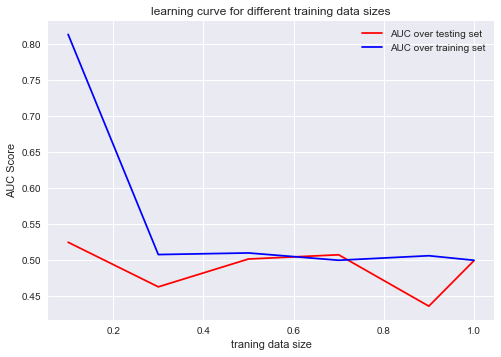

In [121]:
from numpy import *
from matplotlib.pyplot import *
t=[0.1, 0.3, 0.5, 0.7, 0.9, 1]
#y1 = auc_test
#y2 = auc_train
y1 = nn_test_auc
y2 = nn_train_auc
plot(t, y1, 'r-')
hold('on')
plot(t, y2, 'b-')
xlabel('traning data size')
ylabel('AUC Score')
legend(['AUC over testing set', 'AUC over training set'])
title('learning curve for different training data sizes')
show()

In [116]:
# cross validation for NN
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

train_x, train_y = read_train_data("train.csv")
test_x = read_test_data_x("test.csv")
test_y = read_test_data_y("pred.csv")
train_x[np.isnan(train_x)] = 0
test_x[np.isnan(test_x)] = 0
data_x = np.concatenate((train_x, test_x), axis=0)
data_y = np.concatenate((train_y, test_y), axis=0)

idim = 25  # input dimension
hdim1 = 64 # hidden layer one dimension
hdim2 = 64 # hidden layer two dimension
odim = 2   # output dimension
cv_score_nn = []

for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.1)
    model = create_model(idim, odim, hdim1, hdim2) # creating model structure
    trained_model = nn_train(x_train, y_train, model, 300, 0.01, 100) # training model
    cv_score_nn =np.append(cv_score_nn, nn_test(x_test, y_test, trained_model)) # testing model 
print(cv_score_nn)
print(cv_score_nn.mean())

C:\Users\Joey\Anaconda3\lib\site-packages\torch\nn\modules\container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.7368608   0.74573864  0.71803977  0.73046875  0.71697443  0.72088068
  0.75142045  0.73899148  0.74005682  0.73508523]
0.733451704545


In [26]:
# Train a logistic regression classfier
# Use L2 norm and find the best regularizer

from sklearn.metrics import accuracy_score
accuracy = []
for c in [1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1]:
    logreg = linear_model.LogisticRegression(penalty='l2', C=c, multi_class='ovr')
    logreg.fit(train_x, train_y)
    pred_y = logreg.predict(test_x)
    accuracy = np.append(accuracy, accuracy_score(test_y, pred_y))
print(accuracy)

[ 0.59934259  0.67080594  0.68979791  0.6945459   0.68492817  0.69844168]


accuracy_score_test= [ 0.67531045  0.67944972  0.69491113  0.67555393  0.69211103  0.69844168]
accuracy_score_train= [ 0.67586553  0.6808226   0.70277861  0.681499    0.70413509  0.70333032]


C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Joey\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Joey\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


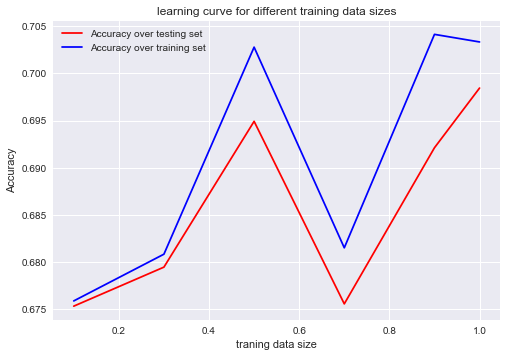

In [46]:
# Calculate accuracy over different training size in order to plot the learning curve
from sklearn.metrics import accuracy_score

accuracy_test = []
for i in [0.1, 0.3, 0.5, 0.7, 0.9, 1]:
    ii = int(i * train_x.shape[0]) 
    logreg = linear_model.LogisticRegression(penalty='l2', C=1, multi_class='ovr')
    logreg.fit(train_x[0:ii,:], train_y[0:ii])
    pred_y = logreg.predict(test_x)
    accuracy_test = np.append(accuracy_test, accuracy_score(test_y, pred_y))
    #auc_test = np.append(auc_test, roc_auc_score(test_y, pred_y))
#print("auc_test=", auc_test)
print("accuracy_score_test=", accuracy_test)

accuracy_train = []
for i in [0.1, 0.3, 0.5, 0.7, 0.9, 1]:
    ii = int(i * train_x.shape[0]) 
    logreg = linear_model.LogisticRegression(penalty='l2', C=1, multi_class='ovr')
    logreg.fit(train_x[0:ii,:], train_y[0:ii])
    pred_y = logreg.predict(train_x[0:ii])
    accuracy_train = np.append(accuracy_train, accuracy_score(train_y[0:ii], pred_y))
    #auc_train = np.append(auc_train, roc_auc_score(train_y, pred_y))
#print("auc_train=", auc_train)
print("accuracy_score_train=", accuracy_train)

# Plot learning curve
from numpy import *
from matplotlib.pyplot import *
t=[0.1, 0.3, 0.5, 0.7, 0.9, 1]
#y1 = auc_test
#y2 = auc_train
y1 = accuracy_test
y2 = accuracy_train
plot(t, y1, 'r-')
hold('on')
plot(t, y2, 'b-')
xlabel('traning data size')
ylabel('Accuracy')
legend(['Accuracy over testing set', 'Accuracy over training set'])
title('learning curve for different training data sizes')
show()


In [60]:
# Concatenate the dataset in order to implement the sklearn CV

from sklearn.model_selection import cross_val_predict
#import dataset
train_x, train_y = read_train_data("train.csv")
test_x = read_test_data_x("test.csv")
test_y = read_test_data_y("pred.csv")
train_x[np.isnan(train_x)] = 0
test_x[np.isnan(test_x)] = 0
data_x = np.concatenate((train_x, test_x), axis=0)
data_y = np.concatenate((train_y, test_y), axis=0)
print(train_y.shape)
print(test_y.shape)
print(data_x.shape)
print(data_y.shape)

(19938,)
(8214,)
(28152, 25)
(28152,)


In [109]:
from sklearn import cross_validation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
logreg = linear_model.LogisticRegression(penalty='l2', C=1, multi_class='ovr')
logreg.fit(data_x, data_y)
cv_score_log = cross_validation.cross_val_score(logreg, data_x, data_y, cv=10)
# cross validation score for logistic regression
print(cv_score_log)
print(cv_score_log.mean())

[ 0.6943557   0.69626998  0.71083481  0.7044405   0.70479574  0.70586146
  0.69769094  0.70408526  0.69769094  0.68383659]
0.699986191425


Accuracy over testing set= [ 0.77392257  0.80472364  0.82213294  0.83004626  0.83223764  0.84258583]
Accuracy over training set = [ 0.99598595  0.94081257  0.91694252  0.89595873  0.89054837  0.88765172]


C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Joey\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Joey\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


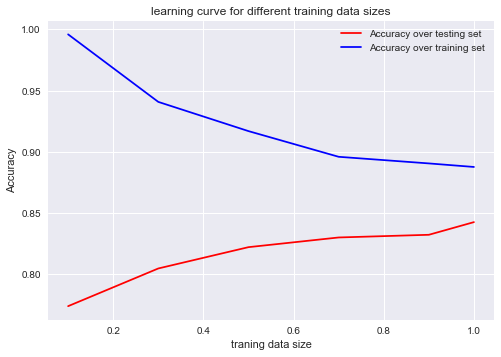

In [68]:
# Train a gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
#import dataset
train_x, train_y = read_train_data("train.csv")
test_x = read_test_data_x("test.csv")
test_y = read_test_data_y("pred.csv")
train_x[np.isnan(train_x)] = 0
test_x[np.isnan(test_x)] = 0

acc_gb_test = []
for i in [0.1, 0.3, 0.5, 0.7, 0.9, 1]:
    ii = int(i * train_x.shape[0]) 
    model = GradientBoostingClassifier(learning_rate=0.1, max_depth=6)
    model.fit(train_x[0:ii,:], train_y[0:ii])
    # make predictions for test data
    y_pred = model.predict(test_x)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    acc_gb_test = np.append(acc_gb_test, accuracy_score(test_y, predictions))
print("Accuracy over testing set=", acc_gb_test)

acc_gb_train = []
for i in [0.1, 0.3, 0.5, 0.7, 0.9, 1]:
    ii = int(i * train_x.shape[0]) 
    model = GradientBoostingClassifier(learning_rate=0.1, max_depth=6)
    model.fit(train_x[0:ii,:], train_y[0:ii])
    # make predictions for test data
    y_pred = model.predict(train_x[0:ii,:])
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    acc_gb_train = np.append(acc_gb_train, accuracy_score(train_y[0:ii], predictions))
print("Accuracy over training set =", acc_gb_train)

# plot the learning curve of Gradient Boosting 
from numpy import *
from matplotlib.pyplot import *
t=[0.1, 0.3, 0.5, 0.7, 0.9, 1]
#y1 = auc_test
#y2 = auc_train
y1 = acc_gb_test
y2 = acc_gb_train
plot(t, y1, 'r-')
hold('on')
plot(t, y2, 'b-')
xlabel('traning data size')
ylabel('Accuracy')
legend(['Accuracy over testing set', 'Accuracy over training set'])
title('learning curve for different training data sizes')
show()

In [107]:
# Use cross validation 
from sklearn import cross_validation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
model = GradientBoostingClassifier(learning_rate=0.1, max_depth=6)
model.fit(data_x, data_y)
cv_score_gb = cross_validation.cross_val_score(model, data_x, data_y, cv=10)
print(cv_score_gb)
print(cv_score_gb.mean())

[ 0.8427405   0.83907638  0.84404973  0.84582593  0.8383659   0.8401421
  0.83765542  0.84618117  0.84120782  0.83232682]


In [128]:
# Use hypothesis test to select for the best model among NN, Logistic, Gradient Boosting 

from scipy import stats
cv_score_gb=[0.8427405, 0.83907638, 0.84404973, 0.84582593, 0.8383659, 0.8401421, 0.83765542, 0.84618117, 0.84120782, 0.83232682]
print(cv_score_gb)
print(cv_score_log)
stats.ttest_rel(cv_score_gb, cv_score_log)
print(cv_score_gb)
print(cv_score_nn)
stats.ttest_rel(cv_score_gb, cv_score_nn)

# Since we are doing multiple hypothesis testing, Bonferroni Correction should be applied
# It turns out gradient boosting is indeed the best model for this dataset 

[0.8427405, 0.83907638, 0.84404973, 0.84582593, 0.8383659, 0.8401421, 0.83765542, 0.84618117, 0.84120782, 0.83232682]
[ 0.6943557   0.69626998  0.71083481  0.7044405   0.70479574  0.70586146
  0.69769094  0.70408526  0.69769094  0.68383659]


Ttest_relResult(statistic=79.372351305581617, pvalue=4.0486600027690317e-14)